# Spyke sorting by SpyKING CIRCUS

 ### _Full pipeline_
 Consists of four steps.

In [14]:
import sys
from pathlib import Path
parent_dir = str(Path(Path().resolve()).parent.parent.resolve())
if parent_dir not in sys.path:
    sys.path.append(parent_dir) 
from circus import launch

Besides the parameters below, all pipleine steps are controlled by the settings read from .params file in the data set directory.

In [16]:
# Set filename to the full path of the main data file:
filename = '/Users/vs/neuro/spyking_circus/test1/20160426_patch3/patch_3.raw'

n_cpus = 1
n_gpus = 0
use_gpu = False if n_gpus == 0 else True

You can enable plotting of intermediate results for specific `electrodes`. \
In the time domain, the signal analysis results will be shown for the period between `t_start`and `t_stop` (s). 

*Note*: Input data are read from intermediate files generated during the analsis rather than from the kernel-allocated memory. This enables running visualization-related cells selectively, without recalculating all the preceding steps of in the analysis pipeline.

In [17]:
show_intermediate_results = True  # Set this to True or False to switch the intermediate plotting on and off resp.

if show_intermediate_results:
    %matplotlib inline
    import sorting
    
    # Set these parameters:
    electrodes = [121, 163]       # Electrode indexes
    t_start=0.                    # Initial time (s)
    t_stop=2.                     # Final time (s)

## 1. Filtering

 Removes low-frequency fluctuations using a third order Butterworth filter.

In [18]:
launch('filtering', filename, n_cpus, n_gpus, use_gpu)

-------------------------  Informations  -------------------------
| Filtering has already been done
| Median over all channels has already been removed
------------------------------------------------------------------


## 2. Whitening

- Removes spurious spatio-temporal correlations between the channels.

- Detects putative spikes as threshold crossings and reduces data dimensionality with the PCA.

In [15]:
launch('whitening', filename, n_cpus, n_gpus, use_gpu)

Analyzing data to get whitening matrices and thresholds...
Found 30s to compute the whitening matrix...
Because of whitening, need to recompute the thresholds...
Searching spikes to construct the PCA basis...


100%|████████████████████████████████████|[03:49<00:00, 76.39s/it]


Found 50240 waveforms over 2016000 requested
-------------------------  Informations  -------------------------
| A basis with 5 dimensions has been built
------------------------------------------------------------------


Spike instances are higlighted with red triangles.


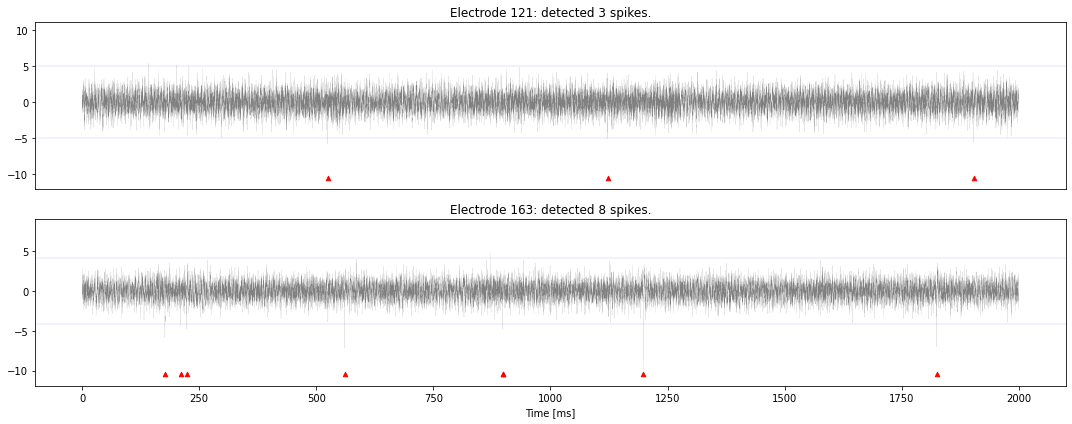

In [19]:
if show_intermediate_results:
    sorting.plot_peaks(filename, t_start, t_stop, electrodes)

## 3. Clustering

The main step of the algorithm. Calculates spatio-temporal templates for spiking activity triggered on the recording electrodes, by clustering a subset of the spikes detected in the previous step. \
The templates are interpreted as recoved signatures of single cells.

In [7]:
launch('clustering', filename, n_cpus, n_gpus, use_gpu)

Searching isolated random spikes to sample amplitudes...


100%|████████████████████████████████████|[04:13<00:00, 84.53s/it]


Found 27506 spikes over 2016000 requested
Estimating amplitudes distributions...
Smart Search of good isolated spikes for the clustering (1/3)...


100%|███████████████████████████████████|[08:40<00:00, 173.43s/it]


Found 27506 isolated spikes over 2016000 requested (0 rejected)
Computing density estimations...
Searching random spikes to refine the clustering (2/3)...


100%|████████████████████████████████████|[03:40<00:00, 73.59s/it]


Found 31 spikes over 2016000 requested
Refining density estimations...
Searching random spikes to refine the clustering (3/3)...


100%|████████████████████████████████████|[03:30<00:00, 70.16s/it]


Found 0 spikes over 2016000 requested
-------------------------  Informations  -------------------------
| No more spikes in the recording, stop searching
------------------------------------------------------------------
Refining density estimations...
Running density-based clustering...


100%|████████████████████████████████████|[00:27<00:00,  9.08it/s]


-------------------------  Informations  -------------------------
| Number of clusters found : 51
| Number of local merges   : 1 (method distance, param 3)
| Not enough spikes gathered: -put safety_space=False?
|                             -remove smart_search?
------------------------------------------------------------------
Estimating the templates with the median-raw procedure ...


100%|████████████████████████████████████|[02:35<00:00,  1.62it/s]


Removing 14 strongly shifted or noisy/mixture templates...
Merging similar templates...


100%|████████████████████████████████████|[00:12<00:00, 20.44it/s]


Removing mixtures of templates...


100%|████████████████████████████████████|[00:11<00:00, 22.14it/s]
100%|████████████████████████████████████|[00:00<00:00, 76.12it/s]


-------------------------  Informations  -------------------------
| Number of global merges    : 0
| Number of mixtures removed : 0
------------------------------------------------------------------
Computing optimal amplitudes for the templates...


100%|████████████████████████████████████|[02:17<00:00,  3.71s/it]
100%|████████████████████████████████████|[01:16<00:00,  3.28it/s]


Pre-computing the overlaps of templates...


100%|████████████████████████████████████|[00:06<00:00, 36.47it/s]


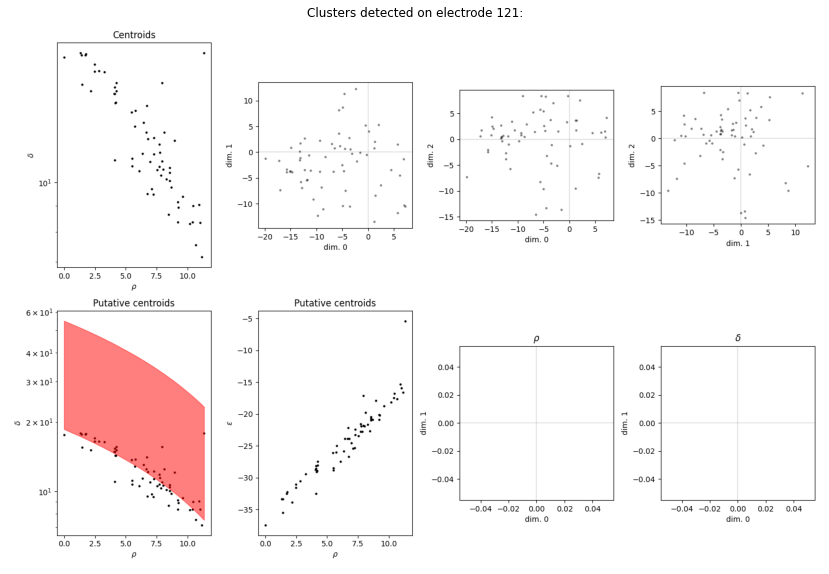

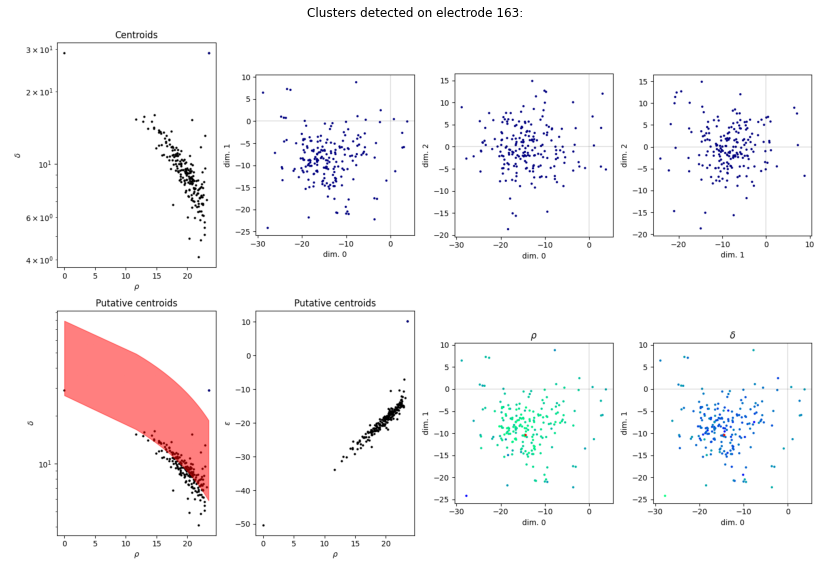

In [20]:
if show_intermediate_results:
    for e in electrodes:
        sorting.show_image(filename, e)

## 4. Fitting

The signal is reconstructed as a linear sum of the templates.

In [10]:
launch('fitting', filename, n_cpus, n_gpus, use_gpu)

Here comes the SpyKING CIRCUS using 1 CPUs and 37 templates...


100%|████████████████████████████████████|[05:19<00:00,  5.63it/s]


Gathering spikes from 1 nodes...


100%|███████████████████████████████████|[00:00<00:00, 124.50it/s]


-------------------------  Informations  -------------------------
| Number of spikes fitted : 36072
------------------------------------------------------------------


Reconstructed signal is shown in red.


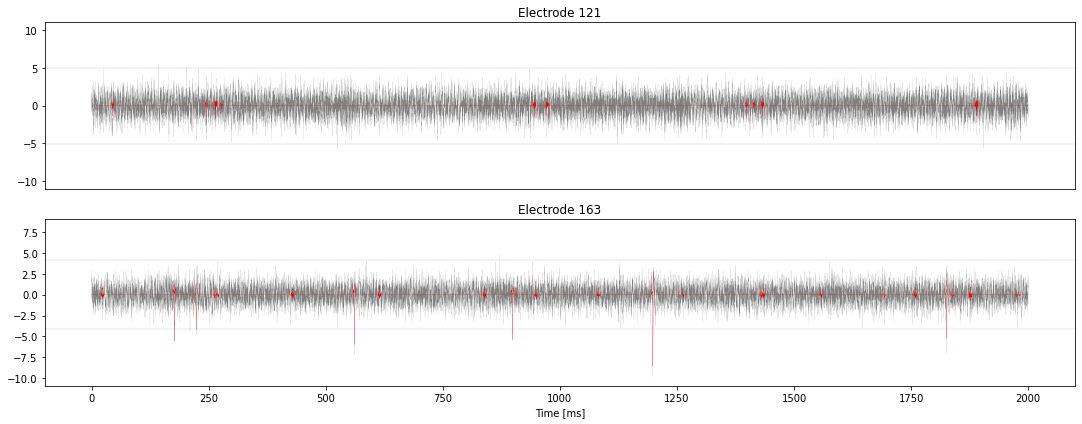

In [21]:
if show_intermediate_results:
    sorting.plot_fits(filename, t_start, t_stop, electrodes)

## Resuts

As the main result, the sorting procedure produces time and amplitude sets characterising the spike events attributed to specific cells. These can be further analyzed using the conventional statistical methods.

For example, the distribution of the inter-spike intervals and the relative spike amplitude: 

In [22]:
import basic_analysis as ba

### ISI distribution
We plot the distribution of inter-spike intervals for each of the spyking cells (colored) and their average (black):

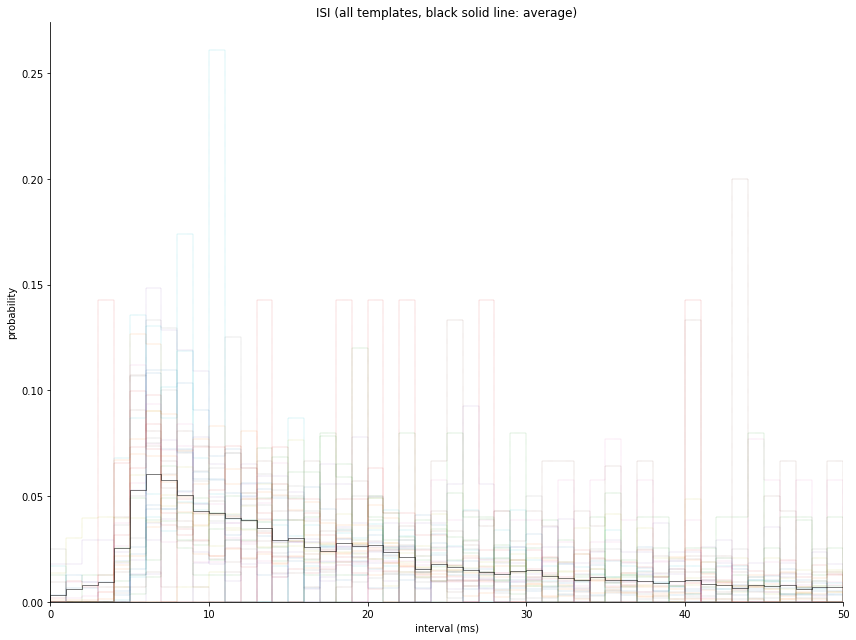

In [23]:
# Set the arguments.
# Template ids are either an iterable containing a set of desired ids or None to see all the templates.
template_ids = None      
maximum_interval=50.0    # ms, histogram will be cut off at this value
bin_size=1.0             # ms

ba.show_isi(filename, template_ids, maximum_interval, bin_size)


### Spike amplitudes

The amplitudes reflect relative intensity of the templates. 

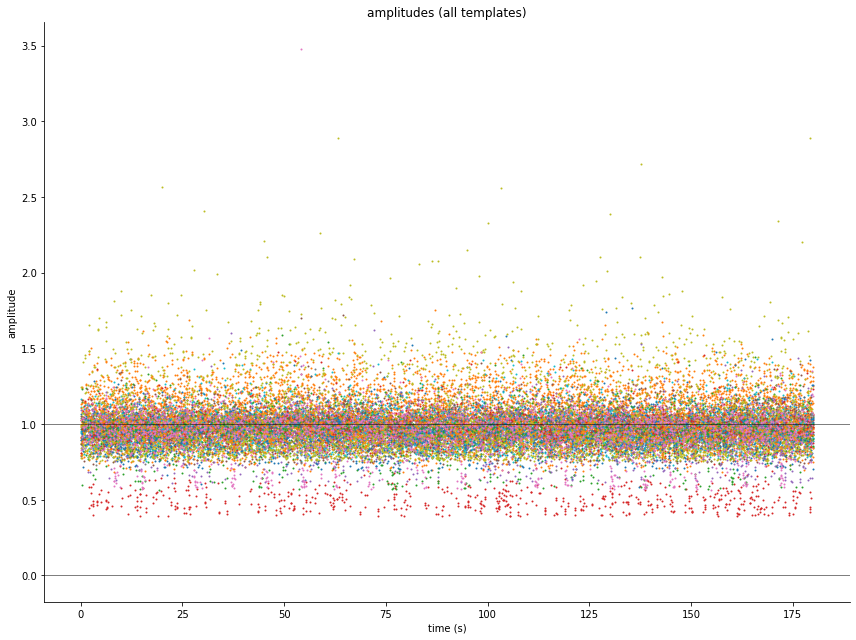

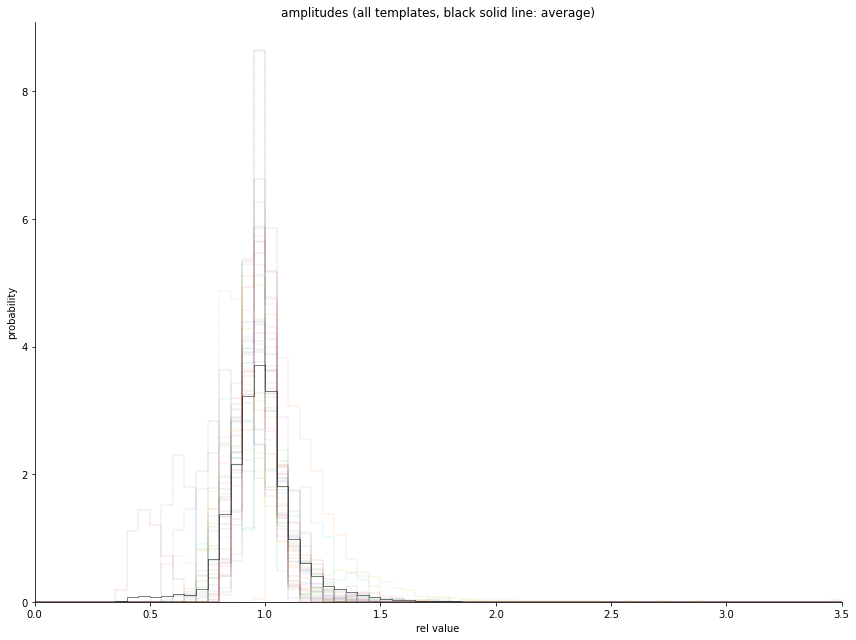

In [25]:
# Set the arguments.
# Template ids are either an iterable containing a set of desired ids or None to see all the templates.
template_ids = None      
bin_size=0.05

ba.show_amplitudes(filename, template_ids)
ba.show_amplitude_hist(filename, template_ids, bin_size=bin_size)
